In [ ]:
# default_exp train.loop

# Loop

Training should be done on a loop: subjects and treatments all getting consistent model evaluation with results stored centrally.  Basically, create reproducible results quickly, automate the easy stuff.

Here I gather a few utilities, practices, interfaces, and demonstrations to make this easier for everyone.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import io
import requests

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
#export
def artifact_storage(*a, **kw):
    """Infer how the user intends to store
    artifacts: models, versions, treatments,
    and evaluation results."""

    def noop(subject, treatment, model, result): pass
    return noop

def generic_runner(subject, treatment, *a, **kw):
    """Naive concept. I have something smarter
    running somewhere, but I'm not sure where it is."""
    storage = artifact_storage(*a, **kw)
    model = None
    result = treatment(subject)
    return storage(subject, treatment, model, result)

def runner(*a, **kw):
    """Infer the runner and its artifact storage."""
    return generic_runner

def train_loop(subjects, treatments, *a, **kw):
    """The main training loop."""

    fn = runner(*a, **kw)

    for subject in np.array(subjects):
        for treatment in np.array(treatments):
            fn(subject, treatment, *a, **kw)

In [ ]:
# This is not normal...expecting to use models, fit, predict,
# hyper parameters, etc.

def t(name, n, subject):
    result = round(subject + n, 2)
    print(f"{name}: {result}")
    return result

def t1(subject): return t('t1', 1, subject)
def t2(subject): return t('t2', 2, subject)

subjects = stats.norm.rvs(size=3) + 10
print(subjects)

train_loop(subjects, [t1, t2])

[ 9.63264311  8.88684748 11.4332921 ]
t1: 10.63
t2: 11.63
t1: 9.89
t2: 10.89
t1: 12.43
t2: 13.43


In [ ]:
#export
def content_from_url(url, decode='utf-8', certs=None, **kw):
    """Use requests to fetch content from a url"""
    kw = {}
    if not certs is None: kw['certs'] = certs
    s = requests.get(url, **kw).content
    if decode is False: return s
    return s.decode(decode)

def white_list(keywords, keys, require_keys=False):
    """Filter a dictionary by a set of keys"""
    if require_keys:
        return {key:keywords[key] for key in keys}
    return {key:keywords.get(key) for key in keys}

def dataframe_from_url(url, **kw):
    """Safely get data, decode it, use certs, and
    create a Pandas DataFrame from the content."""
    content = content_from_url(url, **kw)
    kw = white_list(kw, ['names'])
    return pd.read_csv(io.StringIO(content), **kw)

def values_from_url(url, **kw):
    """Safely get values from a dataframe."""
    df = dataframe_from_url(url, **kw)
    return df.values

def k_fold(**kw):
    """Use scikit-learn's KFold with some control
    on reasonable defaults."""
    defaults = {'n_splits': 10}
    kw = {**defaults, **kw}
    return model_selection.KFold(**kw)

def process_model(name, model, X, Y, storage={}, scoring='accuracy', **kw):
    """Process a model using K-Fold cross validation."""
    kfold = k_fold()
    result = model_selection.cross_val_score(
        model, X, Y,
        cv=kfold, scoring=scoring
    )
    store(name, result, storage=storage)

def store(name, result, storage={}):
    """Simple storage of treatment results."""
    storage[name] = result

def plot_results(results, plot=None, title='Algorithm Comparison', **kw):
    """Create a box plot for each treatment in a results dictionary."""
    if plot is None: plot = plt

    fig = plot.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(list(results.values()))
    ax.set_xticklabels(list(results.keys()))
    plot.show()

def cheap_loop(treatments, subjects, display=True, **kw):
    """Create models without hyperparameter fine tuning
    to determine which algorithms show promise on a particular
    dataset"""
    storage = {}
    for (name, model) in treatments:
        for (x, y) in subjects:
            process_model(name, model(), x, y, storage=storage)
    if display: plot_results(storage, **kw)
    return storage

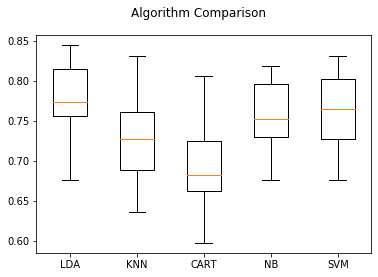

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
array = values_from_url(url, names=names)
X = array[:,0:8]
Y = array[:,8]

treatments = [
#     ('LR', LogisticRegression,
    ('LDA', LinearDiscriminantAnalysis),
    ('KNN', KNeighborsClassifier),
    ('CART', DecisionTreeClassifier),
    ('NB', GaussianNB),
    ('SVM', SVC),
]

subjects = [
    (X, Y)
]

cheap_loop(treatments, subjects);

The cheap_loop is a quick-and-dirty approach to treating data (no hyperparameters are explored).

LogisticRegression is throwing warnings, so I'm just skipping it for now.

Could use some slips, combine some other work I've done, approach different scoring, quite a few other things.